# How to correctly keep class balance using TPU in distributed training

Hi, everyone!

My name is Alex Shonenkov, I am DL/NLP/CV/TS research engineer. Especially I am in Love with NLP & DL.

First of all, I would like to say all of you "Thanks!" for the fact that you find my ideas interesting and useful!

- [[TPU-Inference] Super Fast XLMRoberta](https://www.kaggle.com/shonenkov/tpu-inference-super-fast-xlmroberta)
- [NLP Albumentations](https://www.kaggle.com/shonenkov/nlp-albumentations)
- [Hack with Parallel Corpus](https://www.kaggle.com/shonenkov/hack-with-parallel-corpus)

In this kernel I would like to demonstrate simple technique for keeping balance class during distributed training with PyTorch / XLA


# Motivation

I've studied the best of the best provided public training kernels for this competition and understood, that authors didn't use balance class:
- [I Like Clean TPU Training Kernels & I Can Not Lie](https://www.kaggle.com/abhishek/i-like-clean-tpu-training-kernels-i-can-not-lie) by [@abhishek](https://www.kaggle.com/abhishek)
- [Jigsaw Multilingual Toxicity : EDA + Models 🤬](https://www.kaggle.com/tarunpaparaju/jigsaw-multilingual-toxicity-eda-models) by [@tarunpaparaju](https://www.kaggle.com/tarunpaparaju)
- [Deep Learning For NLP: Zero To Transformers & BERT](https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert) by [@tanulsingh077](https://www.kaggle.com/tanulsingh077)


Thanks a lot all of them for their works!


[@xhlulu](https://www.kaggle.com/xhlulu) said in [discussion](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/discussion/140254):

> Balance your data: The training data set consists of over 2M data points, but it is heavily unbalanced since it only has around 120k positive labels. In order to limit training time, I selected all of the positive labels, and subsampled the negative labels such that I have in total 400k labels, which is a lot closer to the class frequency of the validation labels.


I also think the balance class gives really good boost in this competition!

You can see how [@xhlulu](https://www.kaggle.com/xhlulu) realized balance class keeping:
- [Jigsaw TPU: XLM-Roberta](https://www.kaggle.com/xhlulu/jigsaw-tpu-xlm-roberta) by [@xhlulu](https://www.kaggle.com/xhlulu)


He used sampler with pandas DataFrame:

![](https://i.ibb.co/D8QMZQn/2020-05-01-19-09-45.png)

It has some problems: not all data can participate in training! Also If you used this method in every epoch you can find OOM problems that often meet with XLA / PyTorch

# MAIN IDEA

Lets use modificated pytorch sampler for our loaders for retrieve balanced dataset in streaming! 
Also lets don't forget about distributed training!

I would like to demostrate technique how I decided this problem for my research pipelines.

### I would like to say thanks [Catalyst Team](https://github.com/catalyst-team/catalyst) for creating the great library!

But this library can't use TPU backend for now... 

So let's start!

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null
!python pytorch-xla-env-setup.py --version 20200420 --apt-packages libomp5 libopenblas-dev > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3727  100  3727    0     0  17018      0 --:--:-- --:--:-- --:--:-- 16940
Copying gs://tpu-pytorch/wheels/torch-nightly+20200420-cp36-cp36m-linux_x86_64.whl...

Operation completed over 1 objects/86.8 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200420-cp36-cp36m-linux_x86_64.whl...

Operation completed over 1 objects/117.2 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200420-cp36-cp36m-linux_x86_64.whl...

Operation completed over 1 objects/2.4 MiB.                                      
ERROR: fastai 1.0.60 requires torchvision, which is not installed.
ERROR: catalyst 20.3.3 requires torchvision>=0.2.1, which is not installed.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompati

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
from datetime import datetime
import os
import warnings
from glob import glob
import time

warnings.filterwarnings("ignore")

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

In [3]:
from torch.utils.data.distributed import DistributedSampler
from typing import Iterator, List, Optional
from torch.utils.data.sampler import Sampler
from torch.utils.data.dataset import Dataset
from operator import itemgetter
import numpy as np

##################################
## parts of code from catalyst: ##
##################################

class DatasetFromSampler(Dataset):
    """Dataset of indexes from `Sampler`."""

    def __init__(self, sampler: Sampler):
        """
        Args:
            sampler (Sampler): @TODO: Docs. Contribution is welcome
        """
        self.sampler = sampler
        self.sampler_list = None

    def __getitem__(self, index: int):
        """Gets element of the dataset.
        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """
        if self.sampler_list is None:
            self.sampler_list = list(self.sampler)
        return self.sampler_list[index]

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.sampler)


class DistributedSamplerWrapper(DistributedSampler):
    """
    Wrapper over `Sampler` for distributed training.
    Allows you to use any sampler in distributed mode.
    It is especially useful in conjunction with
    :class:`torch.nn.parallel.DistributedDataParallel`. In such case, each
    process can pass a DistributedSamplerWrapper instance as a DataLoader
    sampler, and load a subset of subsampled data of the original dataset
    that is exclusive to it.
    .. note::
        Sampler is assumed to be of constant size.
    """

    def __init__(
        self,
        sampler,
        num_replicas: Optional[int] = None,
        rank: Optional[int] = None,
        shuffle: bool = True,
    ):
        """
        Args:
            sampler: Sampler used for subsampling
            num_replicas (int, optional): Number of processes participating in
                distributed training
            rank (int, optional): Rank of the current process
                within ``num_replicas``
            shuffle (bool, optional): If true (default),
                sampler will shuffle the indices
        """
        super(DistributedSamplerWrapper, self).__init__(
            DatasetFromSampler(sampler),
            num_replicas=num_replicas,
            rank=rank,
            shuffle=shuffle,
        )
        self.sampler = sampler

    def __iter__(self):
        """@TODO: Docs. Contribution is welcome."""
        self.dataset = DatasetFromSampler(self.sampler)
        indexes_of_indexes = super().__iter__()
        subsampler_indexes = self.dataset
        return iter(itemgetter(*indexes_of_indexes)(subsampler_indexes))

class BalanceClassSampler(Sampler):
    """Abstraction over data sampler.
    Allows you to create stratified sample on unbalanced classes.
    """

    def __init__(self, labels: List[int], mode: str = "downsampling"):
        """
        Args:
            labels (List[int]): list of class label
                for each elem in the datasety
            mode (str): Strategy to balance classes.
                Must be one of [downsampling, upsampling]
        """
        super().__init__(labels)

        labels = np.array(labels)
        samples_per_class = {
            label: (labels == label).sum() for label in set(labels)
        }

        self.lbl2idx = {
            label: np.arange(len(labels))[labels == label].tolist()
            for label in set(labels)
        }

        if isinstance(mode, str):
            assert mode in ["downsampling", "upsampling"]

        if isinstance(mode, int) or mode == "upsampling":
            samples_per_class = (
                mode
                if isinstance(mode, int)
                else max(samples_per_class.values())
            )
        else:
            samples_per_class = min(samples_per_class.values())

        self.labels = labels
        self.samples_per_class = samples_per_class
        self.length = self.samples_per_class * len(set(labels))

    def __iter__(self) -> Iterator[int]:
        """
        Yields:
            indices of stratified sample
        """
        indices = []
        for key in sorted(self.lbl2idx):
            replace_ = self.samples_per_class > len(self.lbl2idx[key])
            indices += np.random.choice(
                self.lbl2idx[key], self.samples_per_class, replace=replace_
            ).tolist()
        assert len(indices) == self.length
        np.random.shuffle(indices)

        return iter(indices)

    def __len__(self) -> int:
        """
        Returns:
             length of result sample
        """
        return self.length

## Examples for usage and understanding:

In [4]:
class DatasetRetriever(Dataset):

    def __init__(self, df):
        self.labels = df['toxic'].values

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        label = self.labels[idx]
        return label
    
    def get_labels(self):
        return list(self.labels )

In [5]:
%%time

df_train = pd.read_csv(f'../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv', index_col='id')

CPU times: user 1.39 s, sys: 226 ms, total: 1.62 s
Wall time: 1.64 s


In [6]:
train_dataset = DatasetRetriever(df_train)

Usually loader:

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    pin_memory=False,
    drop_last=False,
    num_workers=2
)

In [8]:
result = {'toxic': []}
for labels in tqdm(train_loader, total=len(train_loader)):
    result['toxic'].extend(labels.numpy())

100%|██████████| 13972/13972 [00:15<00:00, 892.72it/s]


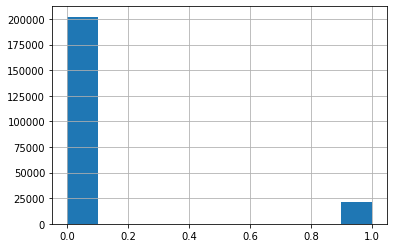

In [9]:
pd.DataFrame(result)['toxic'].hist()

Using balance sampler:

In [10]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode='downsampling'),  # here 2 modes: downsampling/upsampling
    pin_memory=False,
    drop_last=False,
    num_workers=2
)

In [11]:
result = {'toxic': []}
for labels in tqdm(train_loader, total=len(train_loader)):
    result['toxic'].extend(labels.numpy())

100%|██████████| 2673/2673 [00:03<00:00, 737.42it/s]


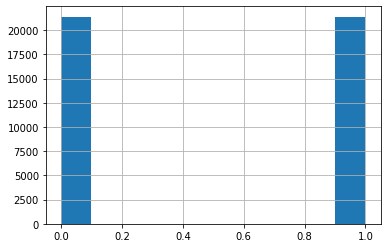

In [12]:
pd.DataFrame(result)['toxic'].hist()

## Now lets to say about distributed usage with this sampler!

usually loader:

In [13]:
def run_experiment1(device):
    if not os.path.exists('experiment1'):
        os.makedirs('experiment1')
        
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=16,
        sampler=train_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=1
    )
    para_loader = pl.ParallelLoader(train_loader, [device])

    result = {'toxic': []}
    for labels in para_loader.per_device_loader(device):
        result['toxic'].extend(labels.cpu().numpy())
    pd.DataFrame(result).to_csv(f'experiment1/result_{datetime.utcnow().microsecond}.csv')

modificated distributed loader with balance class:

In [14]:
def run_experiment2(device):
    if not os.path.exists('experiment2'):
        os.makedirs('experiment2')

    train_sampler = DistributedSamplerWrapper(
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=16,
        sampler=train_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=1
    )
    para_loader = pl.ParallelLoader(train_loader, [device])

    result = {'toxic': []}
    for labels in para_loader.per_device_loader(device):
        result['toxic'].extend(labels.cpu().numpy())
    pd.DataFrame(result).to_csv(f'experiment2/result_{datetime.utcnow().microsecond}.csv')

In [15]:
def _mp_fn(rank, flags):
    device = xm.xla_device()
    run_experiment1(device)
    run_experiment2(device)

FLAGS={}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

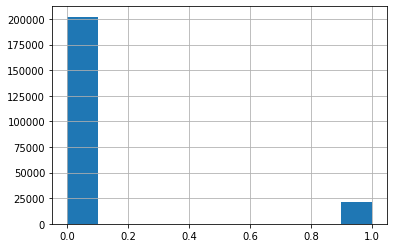

In [16]:
submission = pd.concat([pd.read_csv(path) for path in glob('experiment1/*.csv')])
submission['toxic'].hist()

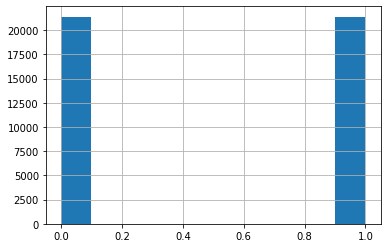

In [17]:
submission = pd.concat([pd.read_csv(path) for path in glob('experiment2/*.csv')])
submission['toxic'].hist()

## Thank you for reading my kernel!

So, I have demonstrated good technique for you, my friends! It will help you avoid OOM problems with training on full data with balance class even distributed training with TPU!

If you like this format of notebooks I would like continue to make kernels with realizations of my ideas.